In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")
from robot_model import *
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cpu")

In [2]:
class ActorCriticSepNetwork(nn.Module):
    def __init__(self, n_observations, n_actions, fc1_dims=512, fc2_dims=512):
        super(ActorCriticSepNetwork, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(n_observations, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions)
        )
        self.critic = nn.Sequential(
            nn.Linear(n_observations, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

    def forward(self, state):
        v = self.critic(state)
        pi = F.softmax(self.actor(state), dim=-1)
        return v, pi
    
    
class ActorCriticSingleNetwork(nn.Module):
    def __init__(self, n_observations, n_actions, fc1_dims=1024, fc2_dims=512):
        super(ActorCriticSingleNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(n_observations, self.fc1_dims)  # Assuming input size is 4
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)
        self.pi = nn.Linear(self.fc2_dims, n_actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        v = self.v(x)
        pi = F.softmax(self.pi(x), dim=-1)

        return v, pi


In [3]:
# Models creation and loading 
n_observations = 6
n_actions = 16

single_ac_linear_reward_1 = ActorCriticSingleNetwork(n_observations, n_actions)
single_ac_linear_reward_1.load_state_dict(torch.load('models/07_ActorCritic1800', weights_only=True))

single_ac_squared_reward_1 = ActorCriticSingleNetwork(n_observations, n_actions)
single_ac_squared_reward_1.load_state_dict(torch.load('models/07_ActorCritic_squaredReward_21_11_24_reward-75', weights_only=True))

separate_ac_linear_reward_1 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_linear_reward_1.load_state_dict(torch.load('models/07_ActorCritic_separate_20_11_24_12-15', weights_only=True))

separate_ac_squared_reward_1 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_1.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward0', weights_only=True))

separate_ac_squared_reward_2 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_2.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward-3', weights_only=True))

separate_ac_squared_reward_3 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_3.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward-7', weights_only=True))

separate_ac_squared_reward_4 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_4.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward-13', weights_only=True))

separate_ac_squared_reward_5 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_5.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward-51', weights_only=True))

separate_ac_squared_reward_6 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_6.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward-67', weights_only=True))

separate_ac_squared_reward_7 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_7.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward-81', weights_only=True))

separate_ac_squared_reward_8 = ActorCriticSepNetwork(n_observations, n_actions)
separate_ac_squared_reward_8.load_state_dict(torch.load('models/07_ActorCritic_separate_squaredReward_21_11_24_reward_average', weights_only=True))

single_ac_linear_reward_p2p = ActorCriticSingleNetwork(12, n_actions)
single_ac_linear_reward_p2p.load_state_dict(torch.load('models/09_ActorCritic_single_linearReward_23_11_24_1800eps_-642', weights_only=True))

single_ac_linear_reward_p2p_zerovel = ActorCriticSingleNetwork(12, n_actions)
single_ac_linear_reward_p2p_zerovel.load_state_dict(torch.load('models/09_ActorCritic_single_linearReward_zerovel_dp_24_11_24_1800eps_-296', weights_only=True))

single_ac_linear_reward_p2p_zerovel2 = ActorCriticSingleNetwork(12, n_actions)
single_ac_linear_reward_p2p_zerovel2.load_state_dict(torch.load('models/09_ActorCritic_single_linearReward_zerovel_dp_24_11_24_1800eps_-296', weights_only=True))

<All keys matched successfully>

In [4]:
robot_model = CDPR4(pos=np.array([.0, .0, 1.]))
dt = 0.1
robot_model.dt = dt
max_force = 15
action_decoder = {
            i: np.array([int(b) for b in f'{i:04b}']) for i in range(16)
        }

def system(model, X, t_span):
    global dt, robot_model
    
    states = np.zeros((t_span.shape[0], X.shape[0]))
    for i in range(t_span.shape[0]):        
        _, out = model(torch.from_numpy(X).float())
        action_n = int(torch.argmax(out).item())
        u = action_decoder[action_n] * max_force
        vel = X[3:6]
        dXdt = np.hstack((vel, np.zeros((3,)))).flatten() + robot_model.B() @ u + np.array([0, 0, 0, 0, 0, -g])
        X[:6] = X[:6] + dt*dXdt.flatten()

        states[i, :] = X
        robot_model.pos = np.copy(X[:3])
        
    return states

In [5]:
eps = 500
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)

sol1 = system(single_ac_linear_reward_1, X, t_span)

In [6]:
import matplotlib.pyplot as plt

def plot_states(sol, t_span):
    plt.figure(figsize=(10, 6))
    plt.plot(t_span, sol[:,0], label='x')
    plt.plot(t_span, sol[:,1], label='y')
    plt.plot(t_span, sol[:,2], label='z')
    plt.plot(t_span, sol[:,3], label='dx')
    plt.plot(t_span, sol[:,4], label='dy')
    plt.plot(t_span, sol[:,5], label='dz')
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title('System')
    plt.legend()
    plt.grid(True)
    plt.show()

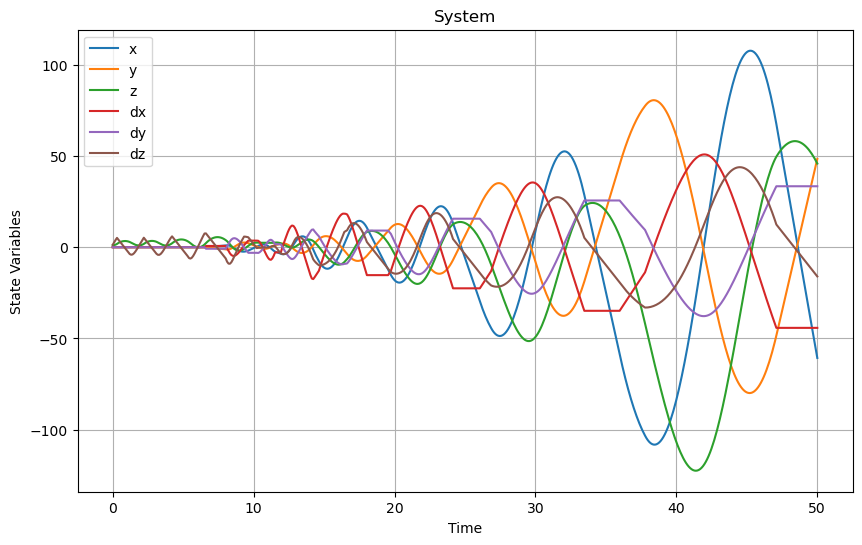

In [7]:
plot_states(sol1, t_span)

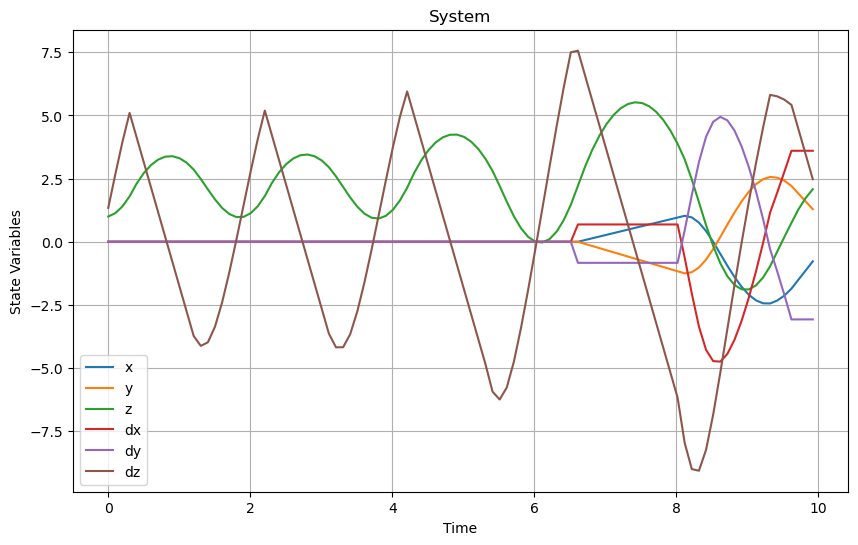

In [8]:
plot_states(sol1[:100,:], t_span[:100])

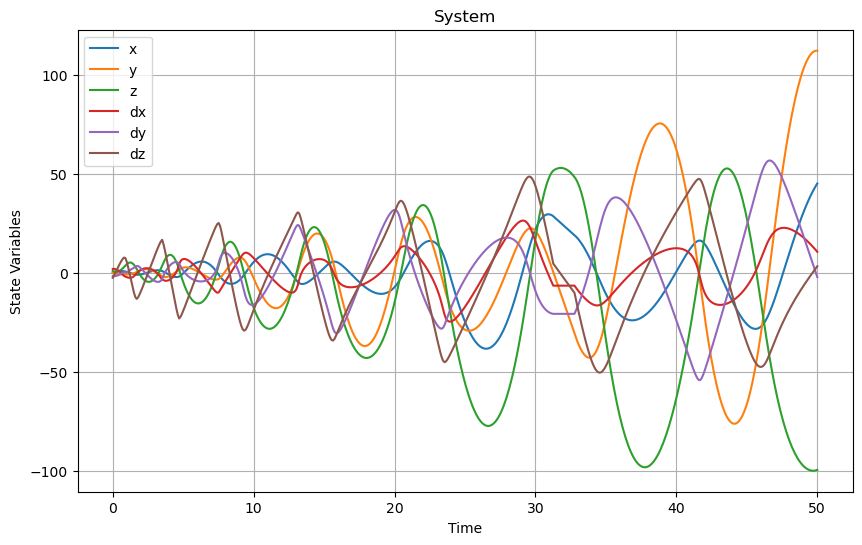

In [9]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol2 = system(single_ac_squared_reward_1, X, t_span)
plot_states(sol2, t_span)

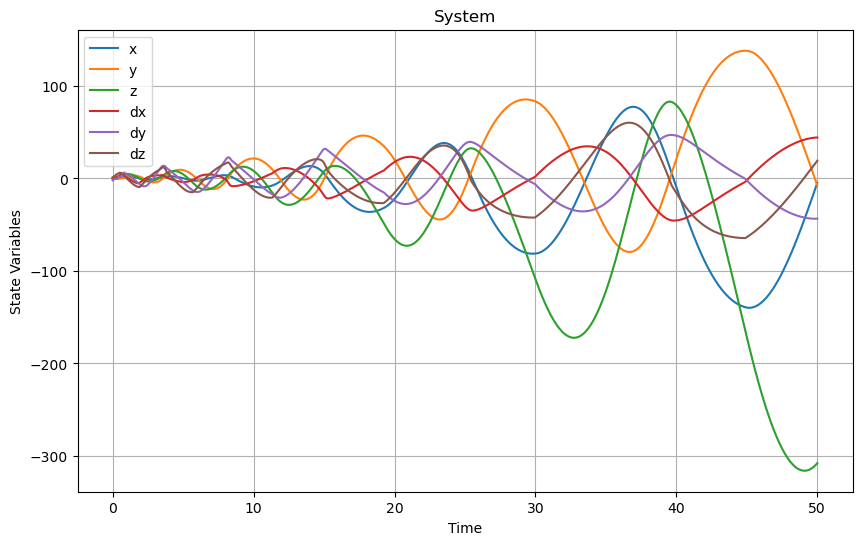

In [10]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol3 = system(separate_ac_linear_reward_1, X, t_span)
plot_states(sol3, t_span)

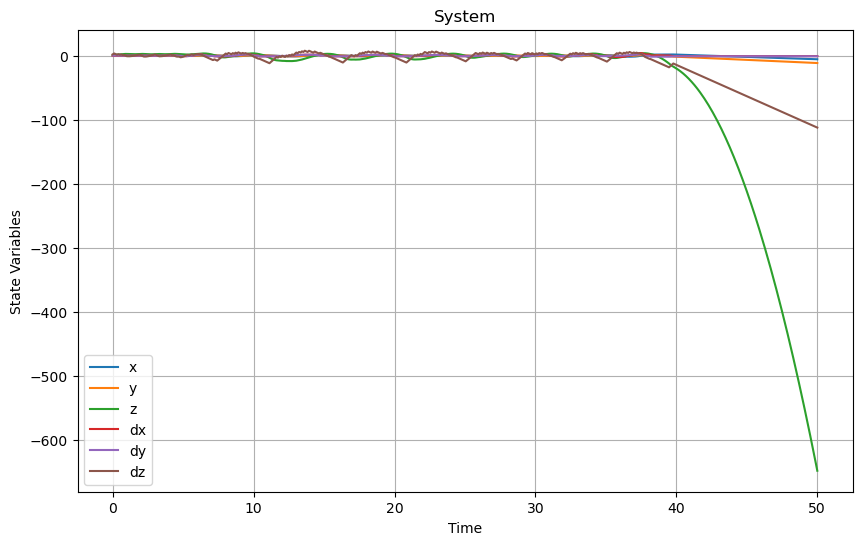

In [11]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol4 = system(separate_ac_squared_reward_1, X, t_span)
plot_states(sol4, t_span)

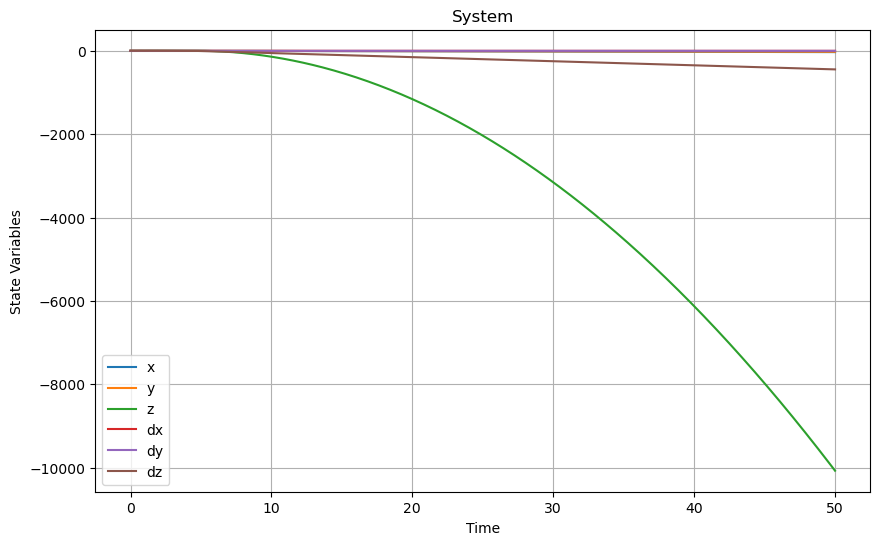

In [12]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol5 = system(separate_ac_squared_reward_2, X, t_span)
plot_states(sol5, t_span)

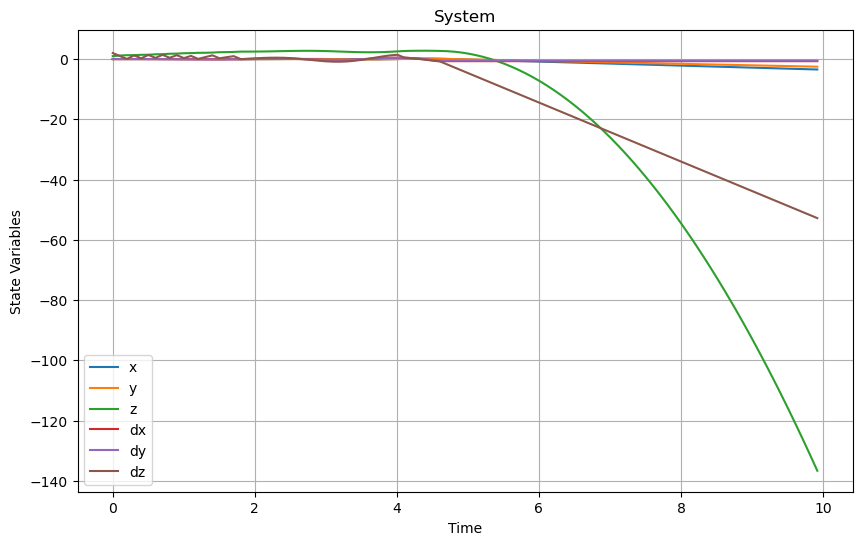

In [13]:
plot_states(sol5[:100,:], t_span[:100])

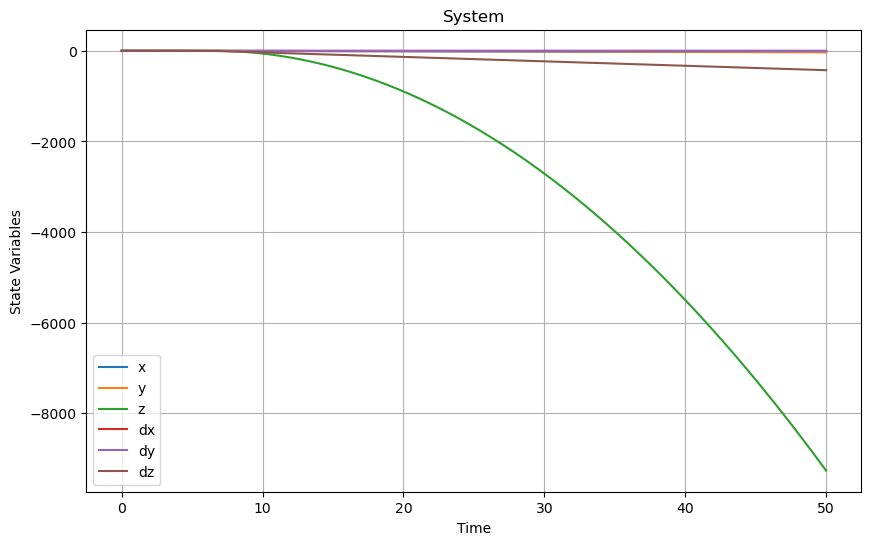

In [14]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol6 = system(separate_ac_squared_reward_3, X, t_span)
plot_states(sol6, t_span)

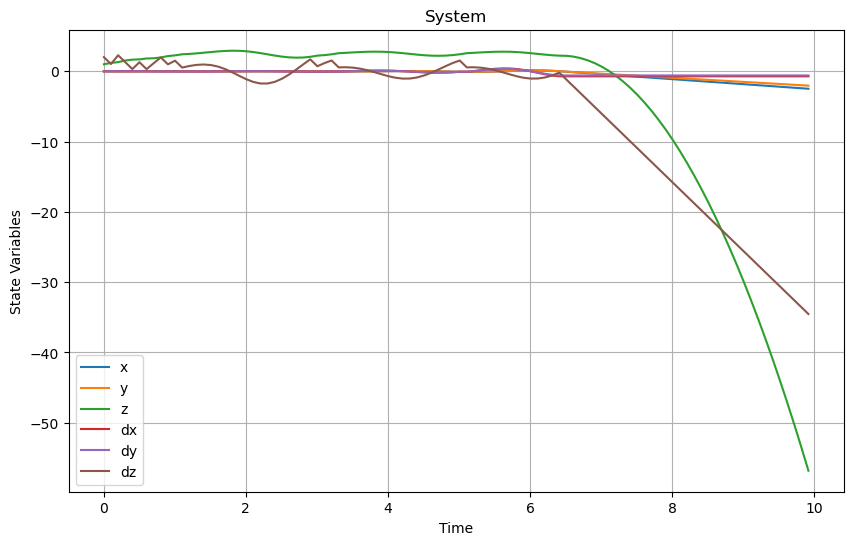

In [15]:
plot_states(sol6[:100,:], t_span[:100])

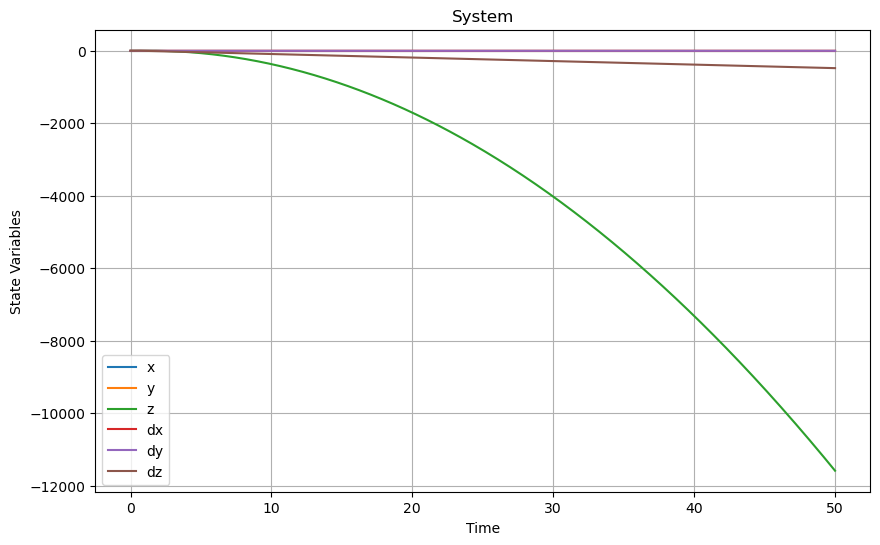

In [16]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol7 = system(separate_ac_squared_reward_4, X, t_span)
plot_states(sol7, t_span)

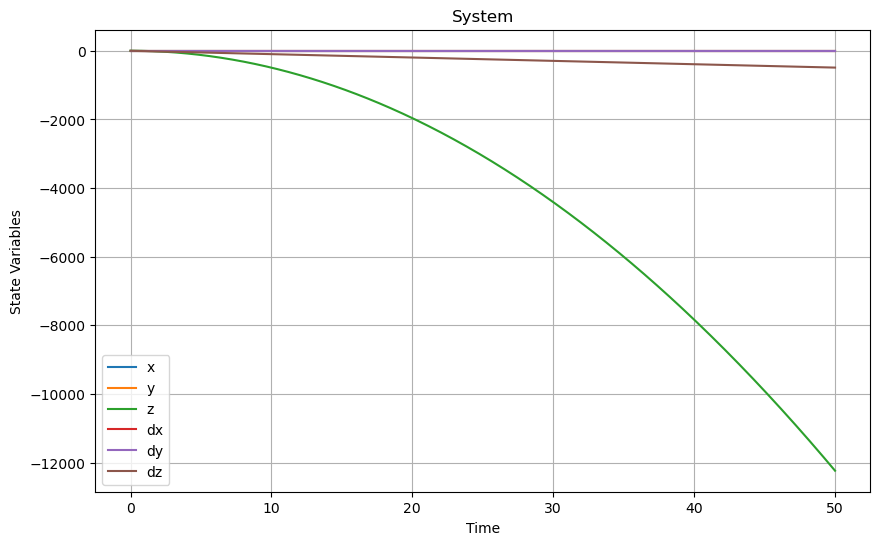

In [17]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol8 = system(separate_ac_squared_reward_5, X, t_span)
plot_states(sol8, t_span)

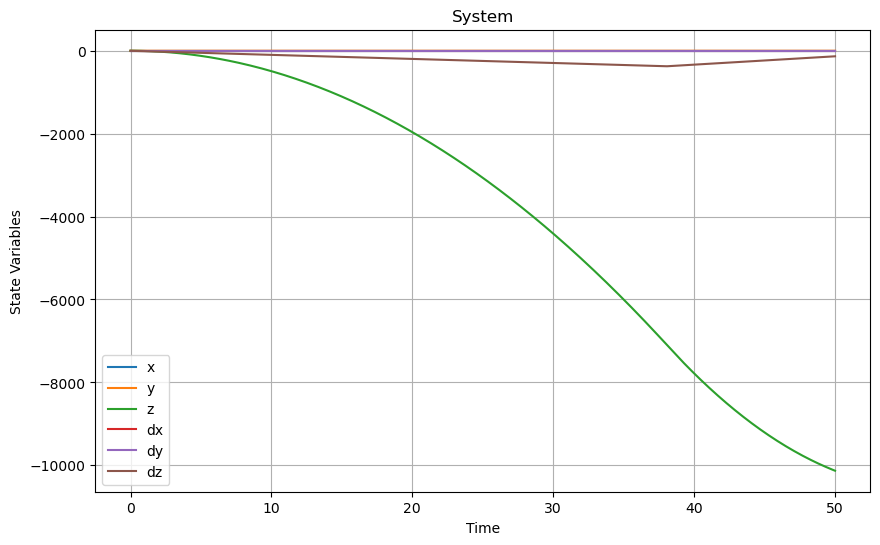

In [18]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol9 = system(separate_ac_squared_reward_6, X, t_span)
plot_states(sol9, t_span)

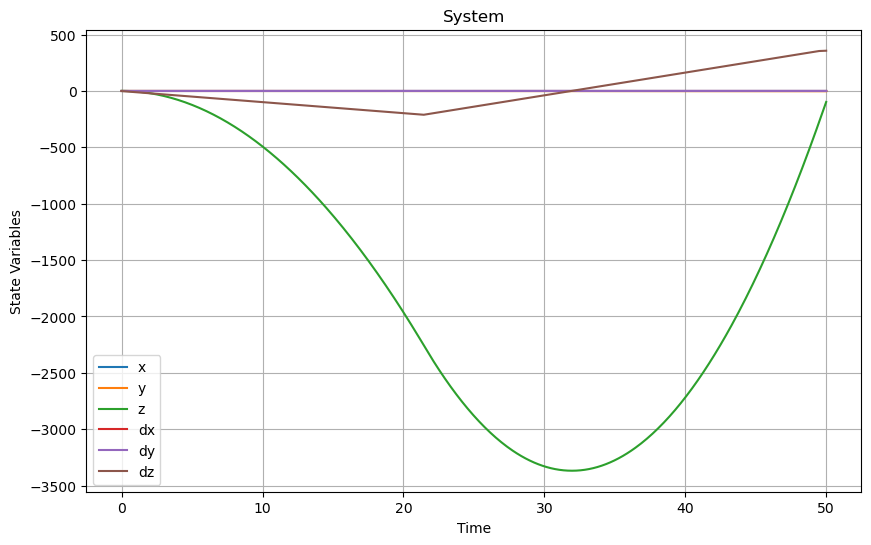

In [19]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol10 = system(separate_ac_squared_reward_7, X, t_span)
plot_states(sol10, t_span)

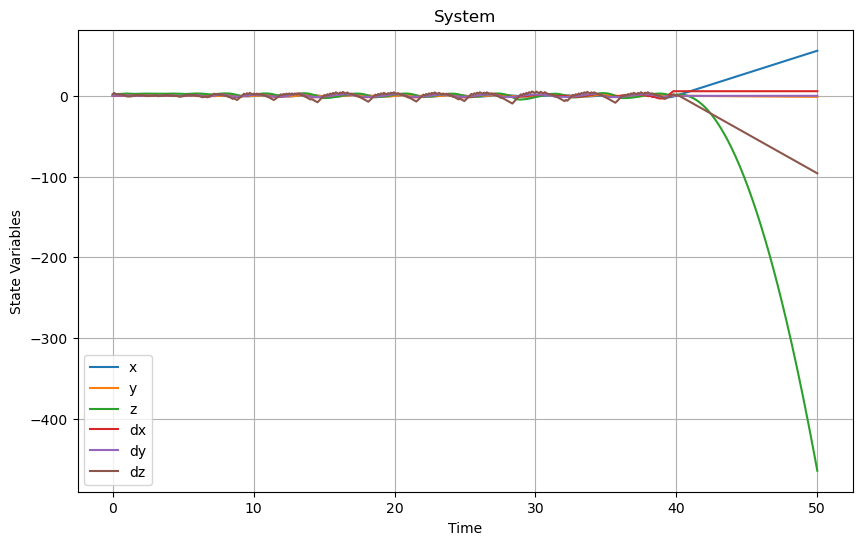

In [20]:
X=np.array([0,0,1,0,0,0], dtype=np.float32)
sol11 = system(separate_ac_squared_reward_8, X, t_span)
plot_states(sol11, t_span)

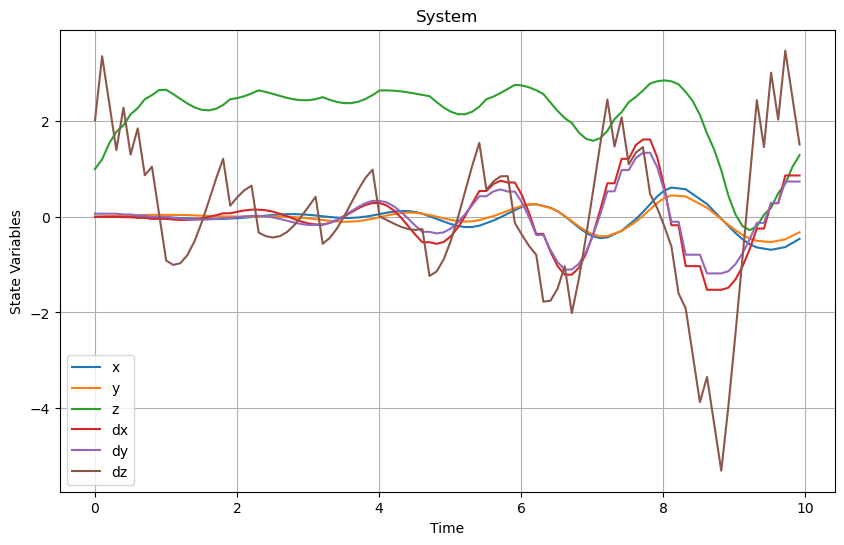

In [21]:
plot_states(sol11[:100,:], t_span[:100])

Now I take the first and last model and change mass of end-effector to 2 kg

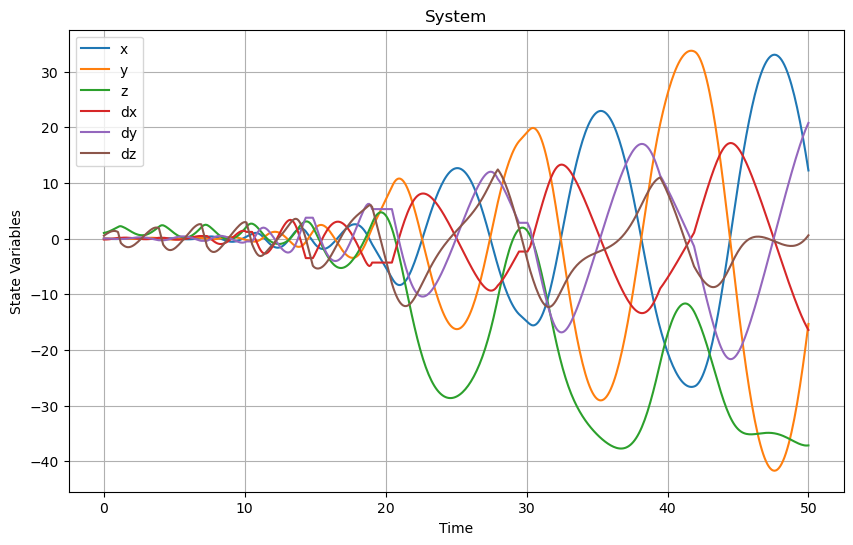

In [22]:
eps = 500
robot_model.m = 2 # 2 kg
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)

sol1_newm = system(single_ac_linear_reward_1, X, t_span)
plot_states(sol1_newm, t_span)

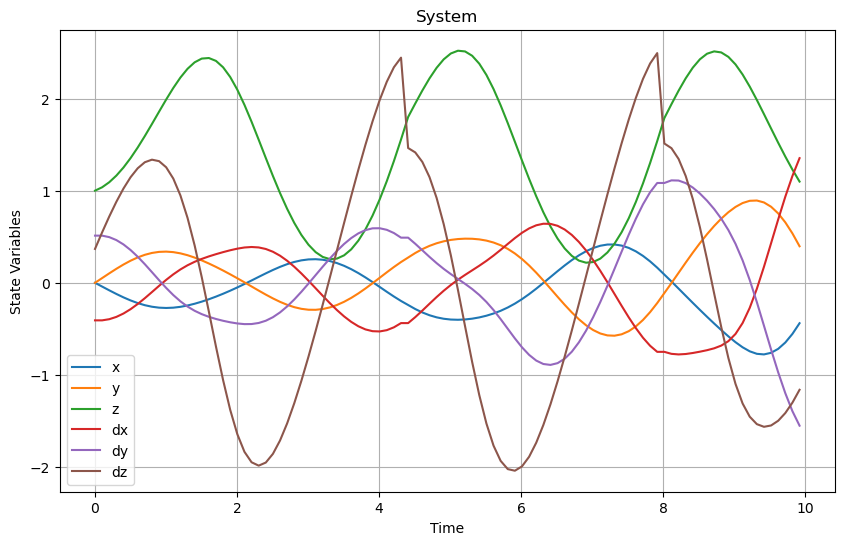

In [23]:
eps = 500
robot_model.m = 2 # 2 kg
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)

sol11_newm = system(separate_ac_squared_reward_8, X, t_span)
plot_states(sol11_newm[:100], t_span[:100])

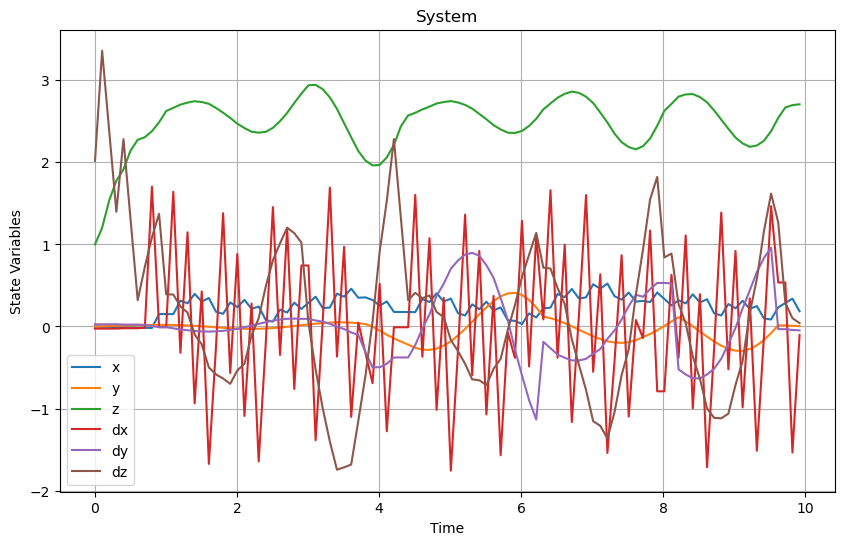

In [24]:
eps = 500
robot_model.m = 1 # 1 kg
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0, 0, 0, 2, 0, 0, 0], dtype=np.float32)
sol12 = system(single_ac_linear_reward_p2p, X, t_span)
plot_states(sol12[:100], t_span[:100])

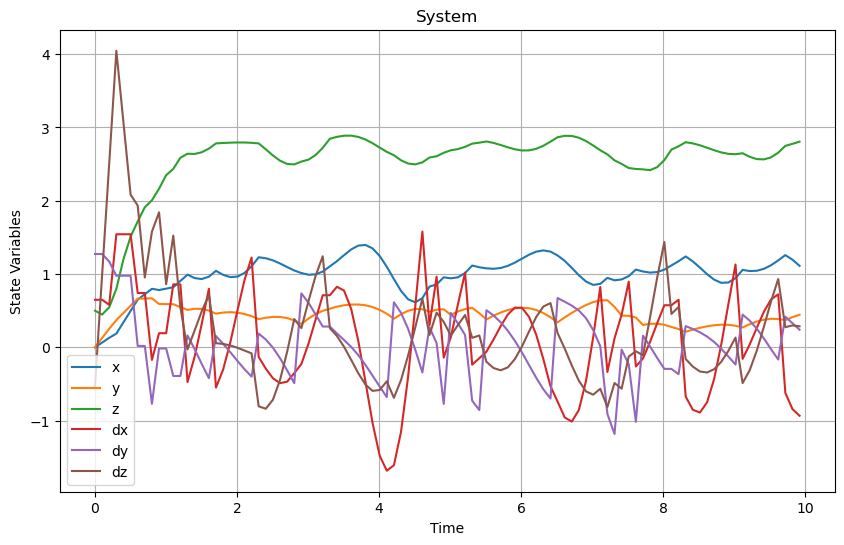

In [25]:
X=np.array([0,0,0.5,0,0,0, 1, 1, 2, 0, 0, 0], dtype=np.float32)
sol12_2 = system(single_ac_linear_reward_p2p, X, t_span)
plot_states(sol12_2[:100], t_span[:100])

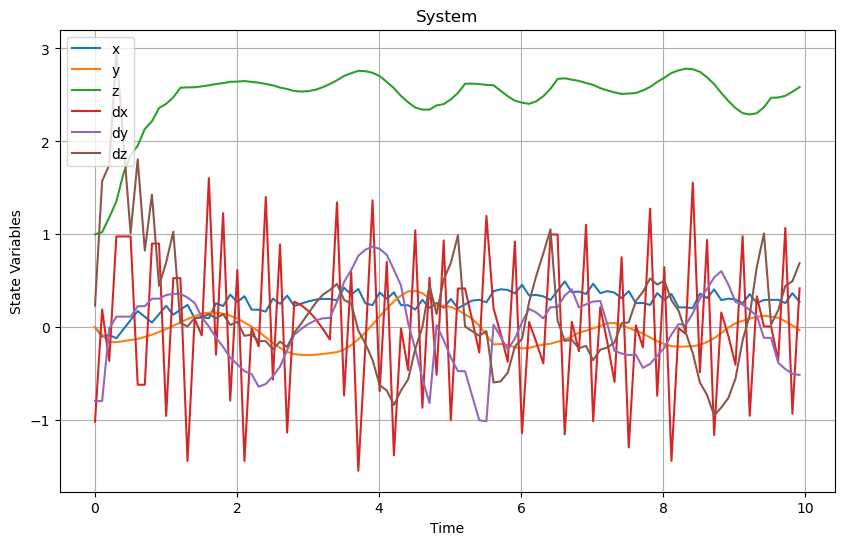

In [26]:
X=np.array([0,0,1,0,0,0, 0, 0, 2, 0, 0, 0], dtype=np.float32)
sol13 = system(single_ac_linear_reward_p2p_zerovel, X, t_span)
plot_states(sol13[:100], t_span[:100])

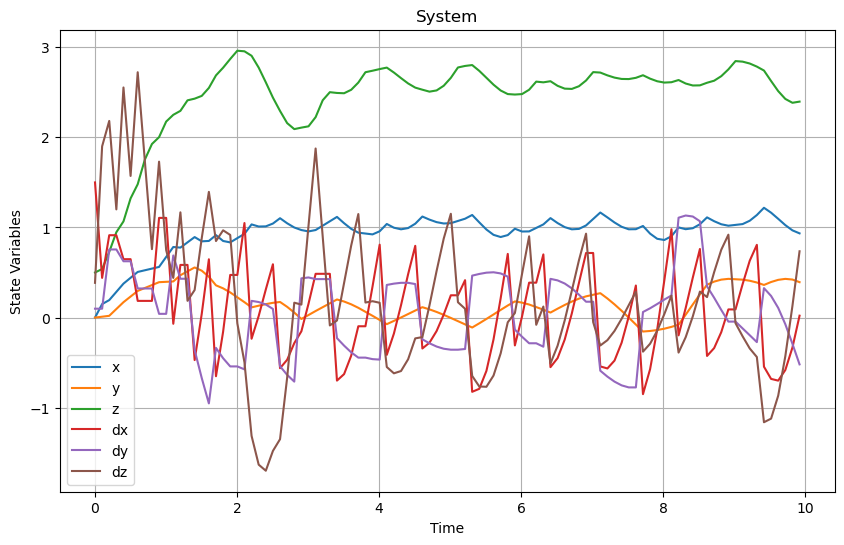

In [27]:
X=np.array([0,0,0.5,0,0,0, 1, 1, 2, 0, 0, 0], dtype=np.float32)
sol13_2 = system(single_ac_linear_reward_p2p_zerovel, X, t_span)
plot_states(sol13_2[:100], t_span[:100])

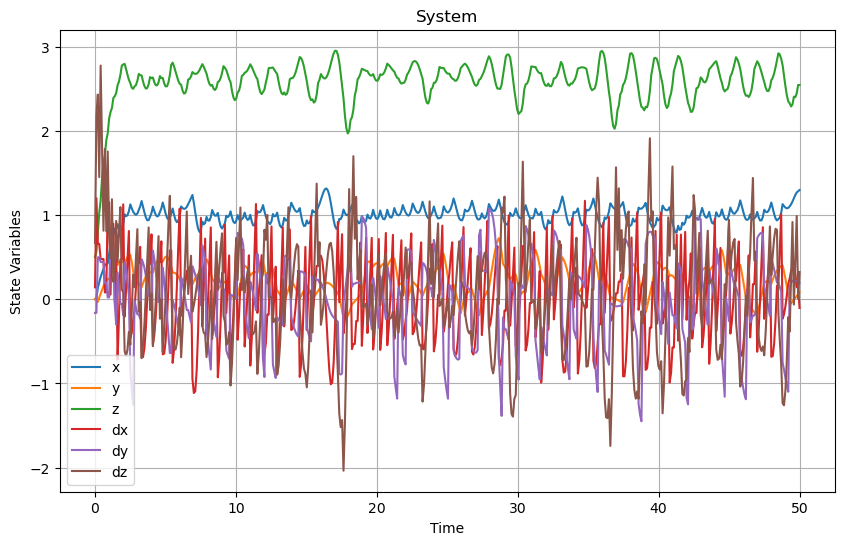

In [29]:
X=np.array([0,0,0.5,0,0,0, 1, 1, 2, 0, 0, 0], dtype=np.float32)
sol14 = system(single_ac_linear_reward_p2p_zerovel2, X, t_span)
plot_states(sol14[:500], t_span[:500])